# Solving MAXCUT Using QAOA in `qiskit` - Warm Start

Optimization problems with integer variables or constraints are often hard to solve. For example, the Quadratic Unconstrained Binary Optimization (QUBO) problem:

$$
\begin{align}
\min_{x\in\{0,1\}^n}x^T\Sigma x + \mu^Tx,
\end{align}
$$


While QUBOs are hard to solve there exists many ways to relax them to problems that are easier to solve. For example, if  is semi-definite positive the QUBO can be relaxed and results in a convex Quadratic Program.


Such relaxations can be leveraged to warm-start quantum optimization algorithms as shown in [1].

In [1]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import json
import networkx as nx
import seaborn as sns

# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import random
import copy

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.problems.variable import VarType

sns.set_theme()


In [2]:
import qiskit
qiskit.__version__

'0.22.0'

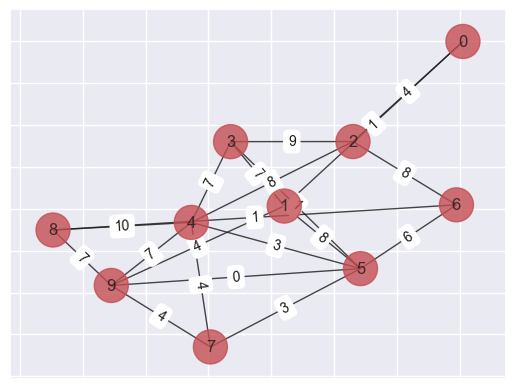

In [3]:
# Generating a graph of 4 nodes
G = nx.connected_watts_strogatz_graph(10,k=4,p=0.5)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(0,10)
    

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
n = 10

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [4]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[ 0.  1.  4.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  7.  0.  8.  0.  0.  0.  4.]
 [ 4.  0.  0.  9.  8.  0.  8.  0.  0.  0.]
 [ 0.  7.  9.  0.  7.  1.  0.  0.  0.  0.]
 [ 0.  0.  8.  7.  0.  3.  0.  4. 10.  7.]
 [ 0.  8.  0.  1.  3.  0.  6.  3.  0.  0.]
 [ 0.  0.  8.  0.  0.  6.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  4.  3.  0.  0.  0.  4.]
 [ 0.  0.  0.  0. 10.  0.  1.  0.  0.  7.]
 [ 0.  4.  0.  0.  7.  0.  0.  4.  7.  0.]]


case = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 5.0
case = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 20.0
case = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 23.0
case = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 29.0
case = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 26.0
case = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 49.0
case = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 44.0
case = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 24.0
case = [1, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 29.0
case = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 30.0
case = [1, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 33.0
case = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 35.0
case = [1, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 32.0
case = [0, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 41.0
case = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 36.0
case = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 39.0
case = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 44.0
case = [0, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 59.0
case = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 62.0
ca

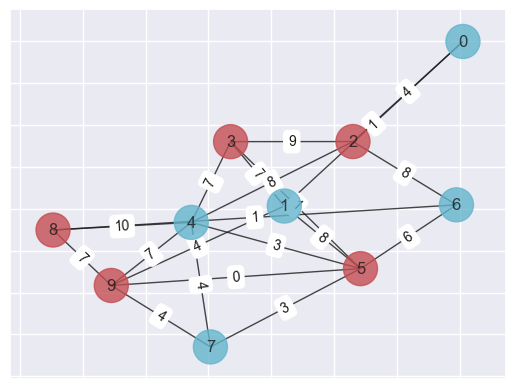

In [5]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

In [6]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 8*x_0*x_2 - 14*x_1*x_3 - 16*x_1*x_5 - 8*x_1*x_9 - 18*x_2*x_3
  - 16*x_2*x_4 - 16*x_2*x_6 - 14*x_3*x_4 - 2*x_3*x_5 - 6*x_4*x_5 - 8*x_4*x_7
  - 20*x_4*x_8 - 14*x_4*x_9 - 12*x_5*x_6 - 6*x_5*x_7 - 2*x_6*x_8 - 8*x_7*x_9
  - 14*x_8*x_9 + 5*x_0 + 20*x_1 + 29*x_2 + 24*x_3 + 39*x_4 + 21*x_5 + 15*x_6
  + 11*x_7 + 18*x_8 + 22*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9



In [46]:
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())
algorithm_globals.random_seed = 12345
quantum_instance = QuantumInstance(
    Aer.get_backend("statevector_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0.0, 1.0])
exact_mes = NumPyMinimumEigensolver()
qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(qp)
print(qaoa_result.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 4*x_0*x_2 - 18*x_0*x_8 - 16*x_1*x_2 - 4*x_1*x_3 - 10*x_2*x_3
  - 16*x_2*x_6 - 12*x_2*x_7 - 18*x_3*x_4 - 10*x_3*x_8 - 2*x_4*x_5 - 6*x_4*x_6
  - 8*x_4*x_7 - 10*x_4*x_9 - 10*x_5*x_6 - 2*x_5*x_8 - 2*x_5*x_9 - 18*x_6*x_9
  - 4*x_8*x_9 + 12*x_0 + 11*x_1 + 29*x_2 + 21*x_3 + 22*x_4 + 8*x_5 + 25*x_6
  + 10*x_7 + 17*x_8 + 17*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

objective function value: 73.0
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0, x_5=0.0, x_6=1.0, x_7=1.0, x_8=0.0, x_9=0.0
status: SUCCESS


In [47]:
def create_problem(mu: np.array, sigma: np.array, total: int = 3) -> QuadraticProgram:
    """Solve the quadratic program using docplex."""

    mdl = Model()
    x = [mdl.binary_var("x%s" % i) for i in range(len(sigma))]

    objective = mdl.sum([mu[i] * x[i] for i in range(len(mu))])
    objective -= 2 * mdl.sum(
        [sigma[i, j] * x[i] * x[j] for i in range(len(mu)) for j in range(len(mu))]
    )
    mdl.maximize(objective)
    cost = mdl.sum(x)
    mdl.add_constraint(cost == total)

    qp = from_docplex_mp(mdl)
    return qp


def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

In [48]:
result = CplexOptimizer().solve(qp)
print(result.prettyprint())

objective function value: 73.0
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0, x_5=0.0, x_6=1.0, x_7=1.0, x_8=0.0, x_9=0.0
status: SUCCESS


In [50]:
qp_rel = relax_problem(QuadraticProgramToQubo().convert(qp))
print(qp_rel.prettyprint())
print(qp.prettyprint())

Problem name: Max-cut

Minimize
  2*x_0*x_1 + 4*x_0*x_2 + 18*x_0*x_8 + 16*x_1*x_2 + 4*x_1*x_3 + 10*x_2*x_3
  + 16*x_2*x_6 + 12*x_2*x_7 + 18*x_3*x_4 + 10*x_3*x_8 + 2*x_4*x_5 + 6*x_4*x_6
  + 8*x_4*x_7 + 10*x_4*x_9 + 10*x_5*x_6 + 2*x_5*x_8 + 2*x_5*x_9 + 18*x_6*x_9
  + 4*x_8*x_9 - 12*x_0 - 11*x_1 - 29*x_2 - 21*x_3 - 22*x_4 - 8*x_5 - 25*x_6
  - 10*x_7 - 17*x_8 - 17*x_9

Subject to
  No constraints

  Continuous variables (10)
    0 <= x_0 <= 1
    0 <= x_1 <= 1
    0 <= x_2 <= 1
    0 <= x_3 <= 1
    0 <= x_4 <= 1
    0 <= x_5 <= 1
    0 <= x_6 <= 1
    0 <= x_7 <= 1
    0 <= x_8 <= 1
    0 <= x_9 <= 1

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 4*x_0*x_2 - 18*x_0*x_8 - 16*x_1*x_2 - 4*x_1*x_3 - 10*x_2*x_3
  - 16*x_2*x_6 - 12*x_2*x_7 - 18*x_3*x_4 - 10*x_3*x_8 - 2*x_4*x_5 - 6*x_4*x_6
  - 8*x_4*x_7 - 10*x_4*x_9 - 10*x_5*x_6 - 2*x_5*x_8 - 2*x_5*x_9 - 18*x_6*x_9
  - 4*x_8*x_9 + 12*x_0 + 11*x_1 + 29*x_2 + 21*x_3 + 22*x_4 + 8*x_5 + 25*x_6
  + 10*x_7 + 17*x_8 + 17*x_9

Subject to
  No constrain

In [54]:
sol = CplexOptimizer(disp=True).solve(qp_rel)
print(sol.prettyprint())

Version identifier: 22.1.0.0 | 2022-03-27 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 19
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 10
  Integer space required    = 10
  Total non-zeros in factor = 55
  Total FP ops to factor    = 385
CPLEX Error  5002: objective is not convex.
QP with an indefinite objective can be solved
to local optimality with optimality target 2,
or to global optimality with optimality target 3.
Presolve time = 0.01 sec. (0.00 ticks)
Barrier time = 0.01 sec. (0.00 ticks)
Error: Model has non-convex objective: 2 x_0 * x_1 + 4 x_0 * x_2 + 18 x_0 * x_8 + 16 x_
objective function value: 0.0
variable values: x_0=0.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=0.0
status: FAILURE


/Users/vivekkatial/.virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit_optimization/algorithms/cplex_optimizer.py:128: UserWarning: CPLEX cannot solve the model
  warn("CPLEX cannot solve the model")


In [52]:
c_stars = sol.samples[0].x
print(c_stars)

[1.0, 1.0, 0, 1.0, 0, 0, 1.0, 1.0, 0, 0]
